In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv


In [2]:
import os
import pandas as pd
import numpy as np
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings('ignore')
from lightgbm import LGBMRegressor
import joblib

# <a id='data'>1. Fetch the data</a>

In [3]:
sales = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv')
sales.name = 'sales'
calendar = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
calendar.name = 'calendar'
prices = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv')
prices.name = 'prices'

Since, the validation data is now available for the days 1914-1941, Adding zero sales for days: d_1942 - d_1969(Test)

In [4]:
#Add zero sales for the remaining days 1942-1969
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)

# <a id='down'>2. Downcasting</a>
In this section I'll be downcasting the dataframes to reduce the amount of storage used by them and also to expidite the operations performed on them.


- **Numerical Columns: ** Depending on your environment, pandas automatically creates int32, int64, float32 or float64 columns for numeric ones. If you know the min or max value of a column, you can use a subtype which is less memory consuming. You can also use an unsigned subtype if there is no negative value.<br>
Here are the different subtypes you can use:<br>
`int8 / uint8` : consumes 1 byte of memory, range between -128/127 or 0/255<br>
`bool` : consumes 1 byte, true or false<br>
`float16 / int16 / uint16`: consumes 2 bytes of memory, range between -32768 and 32767 or 0/65535<br>
`float32 / int32 / uint32` : consumes 4 bytes of memory, range between -2147483648 and 2147483647<br>
`float64 / int64 / uint64`: consumes 8 bytes of memory<br>
If one of your column has values between 1 and 10 for example, you will reduce the size of that column from 8 bytes per row to 1 byte, which is more than 85% memory saving on that column!
- **Categorical Columns: ** Pandas stores categorical columns as objects. One of the reason this storage is not optimal is that it creates a list of pointers to the memory address of each value of your column. For columns with low cardinality (the amount of unique values is lower than 50% of the count of these values), this can be optimized by forcing pandas to use a virtual mapping table where all unique values are mapped via an integer instead of a pointer. This is done using the category datatype.

In [5]:
sales_bd = np.round(sales.memory_usage().sum()/(1024*1024),1)
calendar_bd = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_bd = np.round(prices.memory_usage().sum()/(1024*1024),1)

In [6]:
#Downcast in order to save memory
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

sales = downcast(sales)
prices = downcast(prices)
calendar = downcast(calendar)

In [7]:
sales_ad = np.round(sales.memory_usage().sum()/(1024*1024),1)
calendar_ad = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_ad = np.round(prices.memory_usage().sum()/(1024*1024),1)

Below plot shows how much effect downcasting has had on the memory usage of DataFrames. Clearly, we have been able to reduce `sales` & `prices` to less than 1/4th of their actual memory usage. `calendar` is already a small dataframe.

In [8]:
dic = {'DataFrame':['sales','calendar','prices'],
       'Before downcasting':[sales_bd,calendar_bd,prices_bd],
       'After downcasting':[sales_ad,calendar_ad,prices_ad]}

memory = pd.DataFrame(dic)
memory = pd.melt(memory, id_vars='DataFrame', var_name='Status', value_name='Memory (MB)')
memory.sort_values('Memory (MB)',inplace=True)
fig = px.bar(memory, x='DataFrame', y='Memory (MB)', color='Status', barmode='group', text='Memory (MB)')
fig.update_traces(texttemplate='%{text} MB', textposition='outside',marker_line_width=1.5,marker_line_color='black')
fig.update_layout(template='seaborn', title='Effect of Downcasting',
                 xaxis=dict(linecolor='black',linewidth=2,mirror=True,ticks='inside'),
                 yaxis=dict(linecolor='black',linewidth=2,mirror=True,ticks='inside'))
fig.show()

#  Melting the data


In this case what the melt function is doing is that it is converting the sales dataframe which is in wide format to a long format. I have kept the id variables as `id`, `item_id`, `dept_id`, `cat_id`, `store_id` and `state_id`. They have in total 30490 unique values when compunded together. Now the total number of days for which we have the data is 1969 days. Therefore the melted dataframe will be having 30490x1969 i.e. 60034810 rows

In [9]:
df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()

Combine the data
* Combine price data from prices dataframe and days data from calendar dataset.

In [10]:
df = pd.merge(df, calendar, on='d', how='left')
df = pd.merge(df, prices, on=['store_id','item_id','wm_yr_wk'], how='left') 

#  Exploratory Data Analysis

In [11]:
group_price_store = df.groupby(['state_id','store_id','item_id'],as_index=False)['sell_price'].mean().dropna()
fig = px.violin(group_price_store, x='store_id', color='state_id', y='sell_price',box=True, hover_name='item_id')
fig.update_xaxes(title_text='Store')
fig.update_yaxes(title_text='Selling Price($)')
fig.update_layout(template='seaborn',title='Distribution of Items prices wrt Stores',legend_title_text='State',
                 xaxis=dict(linecolor='black',linewidth=2,mirror=True,ticks='inside'),
                 yaxis=dict(linecolor='black',linewidth=2,mirror=True,ticks='inside'))
fig.show()

Below are some of the observations from the above plot:-
<ul style="list-style-type:circle;">
  <li>The distribution of item prices is almost uniform for all the stores across Califoria, Texas and Wisconsin.</li>
  <li>Item <b>HOBBIES_1_361</b> priced at around 30.5 dollars is the costliest item being sold at walmarts across California.</li>
  <li>Item <b>HOUSEHOLD_1_060</b> priced at around 29.875 dollars is the costliest item being sold at walmarts across Texas.</li>
  <li>Item <b>HOBBIES_1_361</b> priced at around 30.48 dollars is the costliest item being sold at TX_1 and TX_3 in Texas. While item <b>HOBBIES_1_255</b> priced at around 30.5 dollars is the costliest at TX_2</li>
</ul>

In [12]:
group_price_cat = df.groupby(['store_id','cat_id','item_id'],as_index=False)['sell_price'].mean().dropna()
fig = px.violin(group_price_cat, x='store_id', color='cat_id', y='sell_price',box=True, hover_name='item_id')
fig.update_xaxes(title_text='Store')
fig.update_yaxes(title_text='Selling Price($)')
fig.update_layout(template='seaborn',title='Distribution of Items prices wrt Stores across Categories',
                 legend_title_text='Category',xaxis=dict(linecolor='black',linewidth=2,mirror=True,ticks='inside'),
                 yaxis=dict(linecolor='black',linewidth=2,mirror=True,ticks='inside'))
fig.show()

As can be seen from the plot above, food category items are quite cheap as compared with hobbies and household items. Hobbies and household items have almost the same price range.

In [13]:
group = df.groupby(['year','date','state_id','store_id'], as_index=False)['sold'].sum().dropna()
fig = px.violin(group, x='store_id', color='state_id', y='sold',box=True)
fig.update_xaxes(title_text='Store')
fig.update_yaxes(title_text='Total items sold')
fig.update_layout(template='seaborn',title='Distribution of Items sold wrt Stores',legend_title_text='State',xaxis=dict(linecolor='black',linewidth=2,mirror=True,ticks='inside'),
                 yaxis=dict(linecolor='black',linewidth=2,mirror=True,ticks='inside'))
fig.show()

Below are some of the observations from the above plot:-
<ul style="list-style-type:circle;">
  <li><b><u>California</u></b>: <b>CA_3</b> has sold the most number of items while, <b>CA_4</b> has sold the least number of items.</li>
  <li><b><u>Texas</u></b>: <b>TX_2</b> and **TX_3** have sold the maximum number of items. <b>TX_1</b> has sold the least number of items.</li>
  <li><b><u>Wisconsin</u></b>: <b>WI_2</b> has sold the maximum number of items while, <b>WI_3</b> has sold the least number of items.</li>
  <li><b><u>USA</u></b>: <b>CA_3</b> has sold the most number of items while, <b>CA_4</b> has sold the least number of items.</li>
</ul>

**Let's study number of items sold over time across all the stores.**

# Feature Engineering
Time Series data must be re-framed as a supervised learning dataset before we can start using machine learning algorithms.

There is no concept of input and output features in time series. Instead, we must choose the variable to be predicted and use feature engineering to construct all of the inputs that will be used to make predictions for future time steps.


The goal of feature engineering is to provide strong and ideally simple relationships between new input features and the output feature for the supervised learning algorithm to model.



Label Encoding

  <li>Remove unwanted data to create space in RAM for further processing.</li>
  <li>Label Encode categorical features.(I had converted already converted categorical variable to category type. So, I can simply use their codes instead of using LableEncoder)</li>
  <li>Remove date as its features are already present.</li>
</ol>

In [14]:
#Store the categories along with their codes
d_id = dict(zip(df.id.cat.codes, df.id))
d_item_id = dict(zip(df.item_id.cat.codes, df.item_id))
d_dept_id = dict(zip(df.dept_id.cat.codes, df.dept_id))
d_cat_id = dict(zip(df.cat_id.cat.codes, df.cat_id))
d_store_id = dict(zip(df.store_id.cat.codes, df.store_id))
d_state_id = dict(zip(df.state_id.cat.codes, df.state_id))

In [15]:
#1
gc.collect();

#2
df.d = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)
cols = df.dtypes.index.tolist()
types = df.dtypes.values.tolist()
for i,type in enumerate(types):
    if type.name == 'category':
        df[cols[i]] = df[cols[i]].cat.codes
        
#3
df.drop('date',axis=1,inplace=True)

#  Introduce Lags


Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems.

Introduce lags to the the target variable `sold`. The maximum lag I have introduced is 36 days. It's purely upto you how many lags you want to introduce.

In [16]:
#Introduce lags
lags = [1,2,3,6,12,24,36]
for lag in lags:
    df['sold_lag_'+str(lag)] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['sold'].shift(lag).astype(np.float16)

#  Mean Encoding

From a mathematical point of view, mean encoding represents a probability of your target variable, conditional on each value of the feature. In a way, it embodies the target variable in its encoded value.

In [17]:
df['iteam_sold_avg'] = df.groupby('item_id')['sold'].transform('mean').astype(np.float16)
df['state_sold_avg'] = df.groupby('state_id')['sold'].transform('mean').astype(np.float16)
df['store_sold_avg'] = df.groupby('store_id')['sold'].transform('mean').astype(np.float16)
df['cat_sold_avg'] = df.groupby('cat_id')['sold'].transform('mean').astype(np.float16)
df['dept_sold_avg'] = df.groupby('dept_id')['sold'].transform('mean').astype(np.float16)
df['cat_dept_sold_avg'] = df.groupby(['cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
df['store_item_sold_avg'] = df.groupby(['store_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['cat_item_sold_avg'] = df.groupby(['cat_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['dept_item_sold_avg'] = df.groupby(['dept_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['state_store_sold_avg'] = df.groupby(['state_id','store_id'])['sold'].transform('mean').astype(np.float16)
df['state_store_cat_sold_avg'] = df.groupby(['state_id','store_id','cat_id'])['sold'].transform('mean').astype(np.float16)
df['store_cat_dept_sold_avg'] = df.groupby(['store_id','cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)

# Rolling Window Statistics
This method is called the rolling window method because the window would be different for every data point.

I'll be calculating weekly rolling avearge of the items sold. More features like rolling min, max or sum can also be calculated. Also, same features can be calculated for revenue as well.

In [18]:
df['rolling_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)

 Expanding Window Statistics

This is simply an advanced version of the rolling window technique. In the case of a rolling window, the size of the window is constant while the window slides as we move forward in time. Hence, we consider only the most recent values and ignore the past values. Here’s a gif that explains how our expanding window function works:

I'll be calculating expanding avearge of the items sold. More features like expanding min, max or sum can also be calculated. Also, same features can be calculated for revenue as well.

In [19]:
df['expanding_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.expanding(2).mean()).astype(np.float16)

 Trends


I will be creating a selling trend feature, which will be some positive value if the daily items sold are greater than the entire duration average **( d_1 - d_1969 )** else negative. More trend features can be added but I'll only add this one to keep it simple.

In [20]:
df['daily_avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d'])['sold'].transform('mean').astype(np.float16)
df['avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform('mean').astype(np.float16)
df['selling_trend'] = (df['daily_avg_sold'] - df['avg_sold']).astype(np.float16)
df.drop(['daily_avg_sold','avg_sold'],axis=1,inplace=True)

 Save the data


Now since all the new features are created, let's save the data so that it can be trained separately.Also, lags introduce a lot of Null values, so I'll remove data for first 35 days as I have introduced lags till 36 days.

In [21]:
df = df[df['d']>=36]

Let's look at our new dataframe.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58967660 entries, 1067150 to 60034809
Data columns (total 43 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   id                        int16  
 1   item_id                   int16  
 2   dept_id                   int8   
 3   cat_id                    int8   
 4   store_id                  int8   
 5   state_id                  int8   
 6   d                         int16  
 7   sold                      int16  
 8   wm_yr_wk                  int16  
 9   weekday                   int8   
 10  wday                      int8   
 11  month                     int8   
 12  year                      int16  
 13  event_name_1              int8   
 14  event_type_1              int8   
 15  event_name_2              int8   
 16  event_type_2              int8   
 17  snap_CA                   int8   
 18  snap_TX                   int8   
 19  snap_WI                   int8   
 20  sell_price      

Save the data for training.

In [23]:
df.to_pickle('data.pkl')
del df
gc.collect();

# <a id='pred'>6. Modelling and Prediction</a>

In [24]:
data = pd.read_pickle('data.pkl')
valid = data[(data['d']>=1914) & (data['d']<1942)][['id','d','sold']]
test = data[data['d']>=1942][['id','d','sold']]
eval_preds = test['sold']
valid_preds = valid['sold']

In [25]:
#Get the store ids
stores = sales.store_id.cat.codes.unique().tolist()
for store in stores:
    df = data[data['store_id']==store]
    
    #Split the data
    X_train, y_train = df[df['d']<1914].drop('sold',axis=1), df[df['d']<1914]['sold']
    X_valid, y_valid = df[(df['d']>=1914) & (df['d']<1942)].drop('sold',axis=1), df[(df['d']>=1914) & (df['d']<1942)]['sold']
    X_test = df[df['d']>=1942].drop('sold',axis=1)
    
    #Train and validate
    model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=8,
        num_leaves=50,
        min_child_weight=300
    )
    print('*****Prediction for Store: {}*****'.format(d_store_id[store]))
    model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
             eval_metric='rmse', verbose=20, early_stopping_rounds=20)
    valid_preds[X_valid.index] = model.predict(X_valid)
    eval_preds[X_test.index] = model.predict(X_test)
    filename = 'model'+str(d_store_id[store])+'.pkl'
    # save model
    joblib.dump(model, filename)
    del model, X_train, y_train, X_valid, y_valid
    gc.collect()

*****Prediction for Store: CA_1*****
Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 0.843923	training's l2: 0.712206	valid_1's rmse: 0.556612	valid_1's l2: 0.309817
[40]	training's rmse: 0.805702	training's l2: 0.649156	valid_1's rmse: 0.536648	valid_1's l2: 0.287992
[60]	training's rmse: 0.782521	training's l2: 0.612339	valid_1's rmse: 0.529075	valid_1's l2: 0.27992
[80]	training's rmse: 0.765509	training's l2: 0.586004	valid_1's rmse: 0.519001	valid_1's l2: 0.269362
[100]	training's rmse: 0.746824	training's l2: 0.557746	valid_1's rmse: 0.516391	valid_1's l2: 0.26666
[120]	training's rmse: 0.736669	training's l2: 0.542682	valid_1's rmse: 0.512239	valid_1's l2: 0.262389
[140]	training's rmse: 0.725183	training's l2: 0.52589	valid_1's rmse: 0.507517	valid_1's l2: 0.257574
[160]	training's rmse: 0.71879	training's l2: 0.516659	valid_1's rmse: 0.503054	valid_1's l2: 0.253063
[180]	training's rmse: 0.713246	training's l2: 0.508719	valid_1's rmse: 0.5016

**Plotting feature importances**

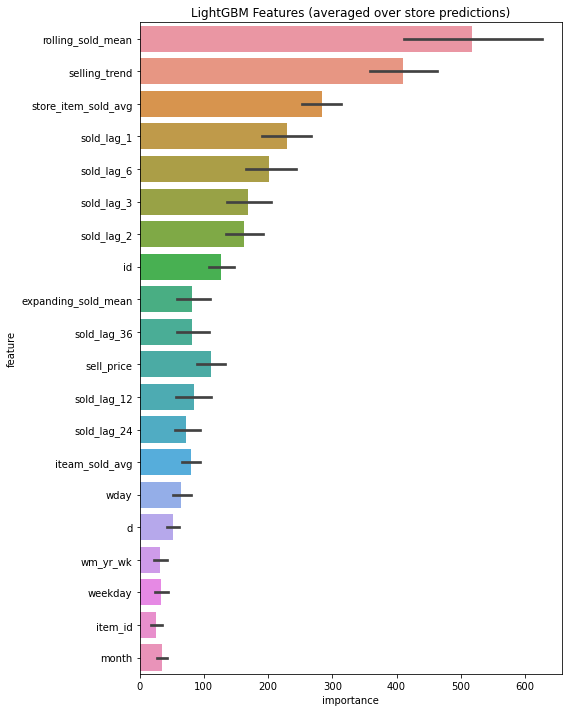

In [26]:
feature_importance_df = pd.DataFrame()
features = [f for f in data.columns if f != 'sold']
for filename in os.listdir('/kaggle/working/'):
    if 'model' in filename:
        # load model
        model = joblib.load(filename)
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (averaged over store predictions)')
    plt.tight_layout()
    
display_importances(feature_importance_df)